## Some examples

### Majority game (a=b=1, c=d=1) on complete graph: $\text{argmax} \ \Phi = \mathcal{N}_\infty = \mathcal N$.

The game admits two Nash equilibria, 'all ones' and 'all zeros', both of them belonging to $\mathcal{N}_\infty$ and both of them global maximizers of the potential (in the majority game the potential counts the links between agents playing the same action). 

Thus: 
- the BR dynamics will converge almost surely in finite time to one of the two configurations (which one depends crucially on the initial condition);
- The NBR with large $\eta$, observed for large times, will spent fraction 1/2 of time in 'all ones' and 1/2 in 'all zeros', indepedently on the initial condition.

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from itertools import product
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.display import Markdown
def print_markdown(string):
    display(Markdown(string))
def printmd(string):
    display(Markdown(string))

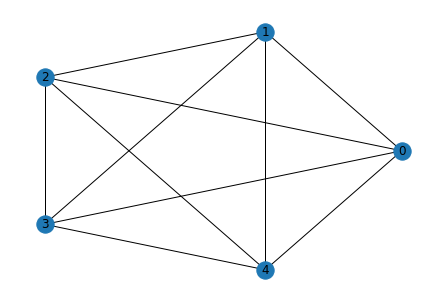

In [3]:
G = nx.complete_graph(5)

pos = nx.circular_layout(G)
nx.draw(G, pos=pos, with_labels=True)

In [4]:
# Define the majority game as a network coordination game

# number of nodes in G = number of players in the game
n_players = len(G)
# utility values
a = 1
b = 1
c = 0
d = 0
# utility matrix for the 2x2 coordination game
phi = np.array([[a,d],
                [c,b]])
# the potential function of the 2x2 coordination game
pot = np.array([[a-c,0],
                [0,b-d]])
# inverse noise parameter
eta = 3
# available actions
actions = [0,1]
n_actions = len(actions)
# adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

def utility(player, x, phi):
    result = 0
    for other_player in G.neighbors(player):
         result += phi[x[player], x[other_player]]
    return result

In [6]:
import scipy as sp

# Define the noisy best response dynamics

# Initialize transition rates matrix
n_config = n_actions**n_players
Lambda = sp.sparse.lil_matrix((n_config,n_config))

# Number of actions for each player
n_states =tuple(n_actions for _ in range(n_players))

# Fill transition rates matrix
for x_id in range(n_config):
    x = np.unravel_index(x_id,shape=n_states)
    x = np.array(x)
    for player in range(n_players):
        # compute utilities gained by `player` for each of its possible actions
        # while the other players are in the current configuration x
        utilities = np.zeros(n_actions)
        for action in actions:
            y = np.array(x)
            y[player] = action
            utilities[action] = utility(player,y,phi)
        exp_utilities = np.exp(eta*utilities)
        for action in actions:
            if action == x[player]:
                continue
            y = np.array(x)
            y[player] = action
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            Lambda[x_id, y_id] += exp_utilities[action] / np.sum(exp_utilities)

In [7]:
# Simulate the continuous time Markov chain with 2nd approach: local clocks
w = np.sum(Lambda, axis=1)

# reshape w
w = np.array(w.T)[0]
for x, weight in enumerate(w):
    # add selfloop if a configuration is a sink, otherwise D is not well defined
    if weight == 0:
        Lambda[x,x] = 1
        w[x] = 1
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# number of iterations
n_steps = 1000000

states = np.zeros(n_steps, dtype=int)
# initial configuration
x = np.random.choice(actions, size = n_players)
x_id = np.ravel_multi_index(tuple(x), dims = n_states)
states[0] = x_id

transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[states[0]]

P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    states[i] = np.argwhere(P_cum[states[i-1]] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w[states[i]]

In [8]:
# compute frequencies
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
frequencies = np.zeros(n_config)

for node in range(n_config):
    visits = np.argwhere(states == node)
    frequencies[node] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
print("Empirical frequencies:", frequencies, "\n")

Empirical frequencies: [5.27157172e-01 3.25354150e-06 3.25637475e-06 7.36639018e-09
 3.23692017e-06 8.02374444e-09 7.83102006e-09 6.54798726e-09
 3.22779359e-06 7.87046134e-09 8.26864195e-09 6.27427090e-09
 7.33018727e-09 6.92441148e-09 7.14889898e-09 2.91045144e-06
 3.26510005e-06 7.43988349e-09 7.98948468e-09 6.72452827e-09
 7.01535684e-09 6.83763393e-09 6.81994374e-09 2.89495603e-06
 7.90276579e-09 7.76055144e-09 8.60408408e-09 2.85786593e-06
 7.30987599e-09 2.88981265e-06 2.91596656e-06 4.72811972e-01] 



As expected, the NBR dynamics spends almost 1/2 of the time on the first configuration, 1/2 on the last configuration (the consensus configurations), and 0 in the other configurations.

**Remark**: if the value of $\eta$ is increased, also the number of steps of the simulation must increase to observe the relaxation to the invariant distribution.

The BR dynamics is much easier. Let us plot two examples of trajectories.

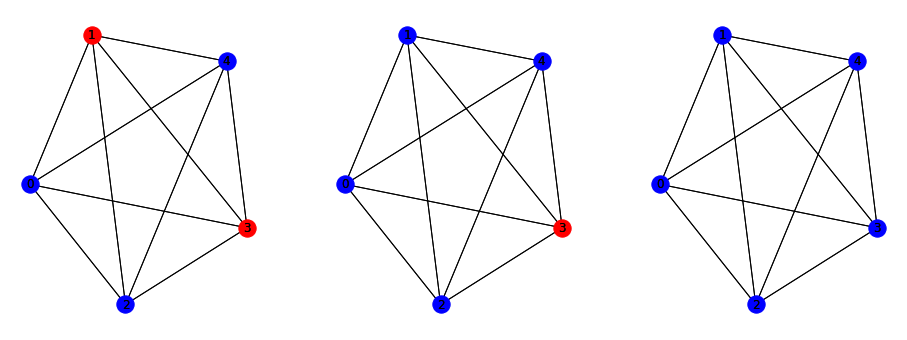

In [9]:
fig = plt.figure(figsize=(16,6))

G = nx.complete_graph(5)
n_nodes = G.number_of_nodes()
pos = nx.spring_layout(G) 

# plot initial condition
x = np.array([1,0,1,0,1])

plt.subplot(1,3,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.array([1,1,1,0,1])

plt.subplot(1,3,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.ones(n_nodes)

plt.subplot(1,3,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

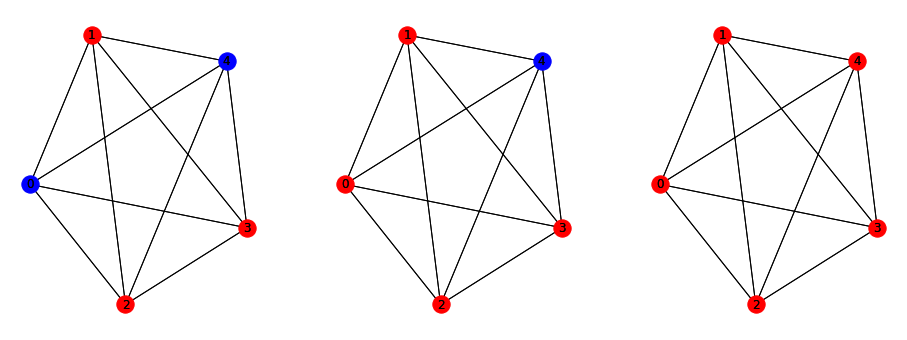

In [10]:
fig = plt.figure(figsize=(16,6))

# plot another initial condition
x = np.array([1,0,0,0,1])

plt.subplot(1,3,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.array([0,0,0,0,1])

plt.subplot(1,3,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.zeros(n_nodes)

plt.subplot(1,3,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

The dynamics always converges to a consensus configuration, and will remain there forever. The empirical frequencies thus converge to $\pi = \delta^{(i)}$, where $i$ is either $(0,0,0,0,0)$ or $(1,1,1,1,1)$. Which consensus is selected depends both on the initial condition and the particular realization of the dynamics.

### Majority game on barbell graph ($n \ge 3$): $\text{argmax} \ \Phi \subset \mathcal{N}_\infty = \mathcal{N}$

The game admits four disconnected Nash equilibria: 'all ones', 'all zeros', and 'all zeros/ones in first complete subgraph and all ones/zeros in the second complete graph'.

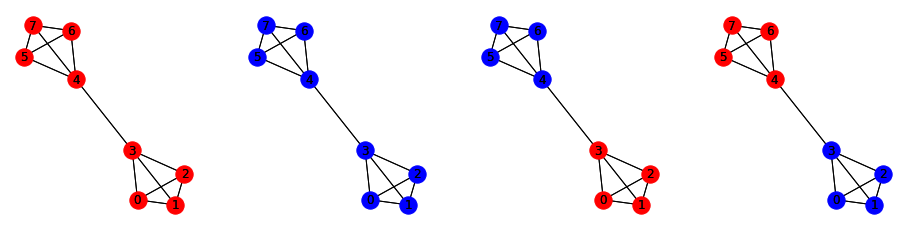

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

fig = plt.figure(figsize=(16,4))

G = nx.barbell_graph(4,0)
n_nodes = G.number_of_nodes()
pos = nx.spring_layout(G) 

# plot first Nash equilibrium
x = np.zeros(n_nodes)

plt.subplot(1,4,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot second Nash equilibrium
x = np.ones(n_nodes)

plt.subplot(1,4,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot third Nash equilibrium
x = np.ones(n_nodes)
x[0:int(n_nodes/2)] = np.zeros(int(n_nodes/2))

plt.subplot(1,4,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot fourth Nash equilibrium
x = np.ones(n_nodes)
x[int(n_nodes/2):n_nodes] = np.zeros(int(n_nodes/2))

plt.subplot(1,4,4)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

- The former two equilibria are global maximizers of the potential, the latter two are not. 
- All of them belong to $\mathcal{N}_\infty$ and no links in the transition graph exist between these four equilibria configurations under the best response dynamics. 
- Thus, the BR dynamics will converge to one of the equilibria and will be stuck from there on. Instead, the NBR (with large $\eta$ and large observation time) will spent 1/2 of the time in each of the consensus configurations, and a vanishing time in the other two equilibria.

### Minority game on complete graph (odd $n$): $\text{argmax} \ \Phi = \mathcal{N}_\infty = \mathcal N$

In this example all these sets are connected.

The game admits many Nash equilibria, that can be distinguished in two classes: the class in which $(n-1)/2$ players play the first strategy, and $(n+1)/2$ players play the second strategy, and the symmetric configurations. 

All these equilibria are global maximizers of the potential, all of them belong to $\mathcal{N}_\infty$ and represent a connected component.

Thus, the BR dynamics will converge to this set of equilibria and continue to move between these configurations. The NBR dynamics will converge in distribution to a uniform distribution of probability on these equilibria, but eventually will hit also the other configurations.

An example of trajectory of the BR dynamics is shown below.

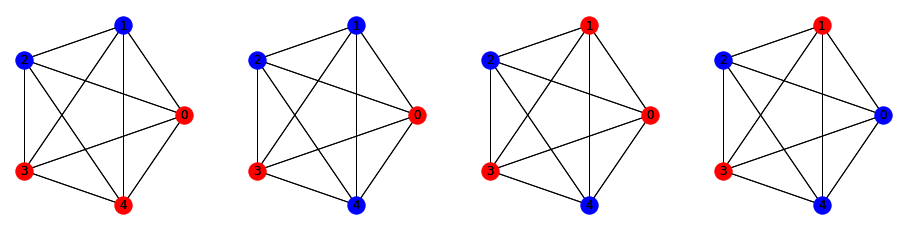

In [12]:
fig = plt.figure(figsize=(16,4))

G = nx.complete_graph(5)
n_nodes = G.number_of_nodes()
pos = nx.circular_layout(G) 

# plot first Nash equilibrium
x = np.array([0,1,1,0,0])

plt.subplot(1,4,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot second Nash equilibrium
x = np.array([0,1,1,0,1])

plt.subplot(1,4,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot third Nash equilibrium
x = np.array([0,0,1,0,1])

plt.subplot(1,4,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot fourth Nash equilibrium
x = np.array([1,0,1,0,1])

plt.subplot(1,4,4)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

### Minority game on a line ($n=4$): $\text{argmax} \ \Phi = \mathcal{N}_\infty \subset \mathcal{N}$.

Each Nash equilibrium satisfies the condition that $x_1 \neq x_2$, $x_4 \neq x_3$, otherwise players $1$ and $4$ are not playing best-response. All the other configurations are Nash equilibria.

The game admits $4$ Nash equilibria:

- (0,1,0,1);
- (1,0,1,0);
- (0,1,1,0);
- (1,0,0,1);

Let us plot these configurations

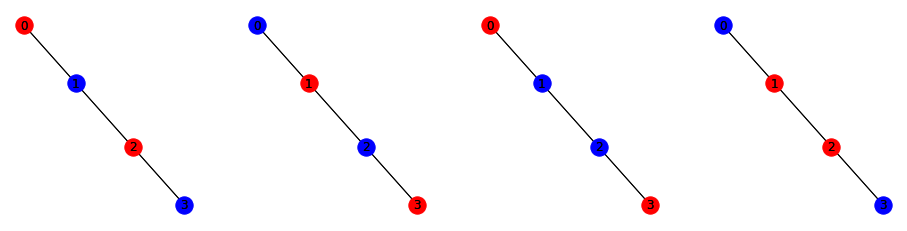

In [13]:
fig = plt.figure(figsize=(16,4))

G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3)])
n_nodes = G.number_of_nodes()
pos = nx.spring_layout(G)

# plot first Nash equilibrium
x = np.array([0,1,0,1])

plt.subplot(1,4,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot second Nash equilibrium
x = np.array([1,0,1,0])

plt.subplot(1,4,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot third Nash equilibrium
x = np.array([0,1,1,0])

plt.subplot(1,4,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot fourth Nash equilibrium
x = np.array([1,0,0,1])

plt.subplot(1,4,4)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

- The first two configurations belong to $\mathcal{N}_\infty$. Indeed, both the equilibria are strict (i.e., each player has a unique best-response to this configuration) and thus are sinks for the best response dynamics. 
- They also maximize the potential, which for the minority game is the number of links between agents playing a different strategy.

- The latter two equilibria do not belong to $\mathcal{N}_\infty$, i.e., the best response dynamics can escape from them. Indeed, the following transition are allowed: (0,1,1,0) -> (0,0,1,0) -> (1,0,1,0). The dynamics then gets trapped in (1,0,1,0). Thus, the BR dynamics will get stuck in either (1,0,1,0) or (0,1,0,1) in finite time with probability 1. This shows that in general $\mathcal{N} \neq \mathcal{N}_\infty$.

- Since the first two configurations coincide with the maximizers of the potential, the NBR (with large $\eta$, observed for long times) will spent 1/2 of the time in (0,1,0,1) and 1/2 of the time in (1,0,1,0).